<a href="https://colab.research.google.com/github/ivoytov/manhattan/blob/master/momentum_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [826]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from typing import Tuple, List

# Loans


##  Identifying Events

### Data Sources ###
Loan data is from Bloomberg BVAL, based on end of day price valuation. Loan list is compiled by screening for:

1.   Active Loans
2.   First Lien Rank
3.   Incorporated in the U.S.
4.   Denominated in USD
5.   \>= $1B outstanding
6.   Non-Investment Grade Rating from either S&P *or* Moody's

The screen is run as of the last day of every quarter (3/31, 6/30, 9/30, and 12/31). Loans that mature or expire during a quarter are included in that quarterly period, but are removed from the screen for the following quarter.

### Data Format

* `loan_data` - Loan IDs are arranged as separate columns, with the first column containing the date index. Price is listed as values in XX.XX format (% of par). If price is unavailable, then #N/A is listed. Trading days only. There are two files, one for loans from 12-31-2018 to 10-15-2020 period, and one for the 12-31-2015 to 12-31-2018 period.

* `loan_desc` - Loan IDs are arranged in the first column, with subsequent columns containing metadata on the loan.

* `periods` - Quarters are listed as separate columns. Loan IDs from the above-mentioned screen are listed under the column header with the `as of` date.

In [827]:
# read in historical prices
#prefix = '/content/drive/MyDrive/'
prefix = '~/bloomberg/'
prices_2020 = pd.read_csv(prefix + 'loans/price_data_2020_stub.csv', parse_dates=['Dates'], index_col='Dates')
prices_2019_2020 = pd.read_csv(prefix + 'loans/price_data_2019-2020.csv', parse_dates=['Dates'], index_col='Dates')
prices_2016_2018 = pd.read_csv(prefix + 'loans/price_data_2016-2018.csv', parse_dates=['Dates'], index_col='Dates')
prices_2013_2015 = pd.read_csv(prefix + 'loans/price_data_2013-2015.csv', parse_dates=['Dates'], index_col='Dates')

prices = pd.concat([prices_2013_2015, prices_2016_2018, prices_2019_2020, prices_2020], join="outer", verify_integrity=True)
print("(# dates, # tickers)", prices.shape)
prices = prices.fillna(method="pad")

(# dates, # tickers) (2000, 1266)


Below is a price graph of the trading history of every loan that breached price of ~85 for the first time, for a 10 trading period before the breach and 10 day period after the breach. The mean is shown in thick blue. There is a slight upward momentum observed in loans that breach 85 for the following 5-7 trading days.

In [828]:
def plotPricesAfterBigMove(prices: pd.DataFrame, trgtPrice: float = None, priceRange: float = 2., bigMove: float = 3.,  numDays: int = 10) -> None:
  out = pd.DataFrame()
  for ticker in prices:
    close = prices[ticker]
    price_filter = (close > trgtPrice - priceRange) & (close < trgtPrice + priceRange) if trgtPrice else 1
    try:
      if bigMove > 0:
        t0 = close[(close.diff(periods=numDays) > bigMove) & price_filter].index[0]
      else:
        t0 = close[(close.diff(periods=numDays) < bigMove) & price_filter].index[0]
    except:
      # loan never met criteria, skip
      continue
    yx = close.iloc[close.index.get_loc(t0) - numDays:close.index.get_loc(t0) + numDays]
    yx.index = range(-numDays,len(yx.index)-numDays)
    out = pd.concat([out, yx], axis=1)

  if len(out):
    p = '{:2.2f}'.format(out.loc[0].median())
    out = out / out.loc[0] - 1  
    print("Median price of event trigger", p)
    out = out.rename_axis("Trading Days before/after Event")
    out.plot(kind="line", legend=False, colormap="binary", linewidth=.3, ylabel=f"Price (% Gain from {p})", title="All Tickers")  
    plt.figure()
    out.T.median().plot(linewidth=3, ylabel=f"Price (% Gain from {p})", title="Median")

In [829]:
HOLD_DAYS = 12
BIG_MOVE = 2
LOOKBACK_DAYS = 10
TARGET_PRICES = [90, 999]  # Disable shorting of loans by setting target price to a number >100
PRICE_RANGE = 5
PT_SL = [1, 5]
MIN_RET = 0.02

Median price of event trigger 90.88


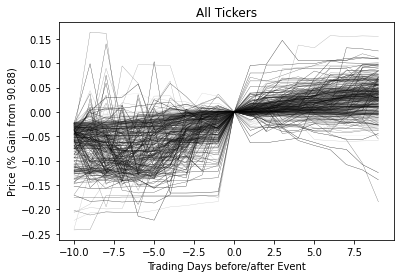

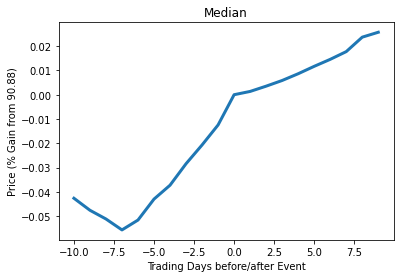

In [830]:
plotPricesAfterBigMove(prices, trgtPrice=TARGET_PRICES[0], priceRange=PRICE_RANGE, bigMove=BIG_MOVE, numDays=LOOKBACK_DAYS)

Same analysis, but for loans that decline in price below 91. There is a stronger negative momentum effect, most likely due to a few cases that declined by 20% or more. The trend reverts sligtly after 5 days but is still meaningful.

In [831]:
plotPricesAfterBigMove(prices, trgtPrice=TARGET_PRICES[1], priceRange=PRICE_RANGE, bigMove=-BIG_MOVE, numDays=LOOKBACK_DAYS)

The trading strategy is to buy every loan that has appreciated by at least 3% (`BIG_MOVE`) and traded into 83-87 price range (`BUY_PRICE_RANGE`) and to short every loan that traded into 88-92 price range while declining by the big move amount. To calculate the decline, we compare the price from 10 days ago (`LOOKBACK_DAYS`) to today, and put the trade on in the following trading session. To smooth out and reduce amount of spurious trading, we use a geometric moving average of the price to determine the signal but with only a 2 day span (given the very short term nature of this signal, a longer span period means we miss the period when the alpha is realized). We hold the position for a maximum of 10 days (`HOLD_DAYS`) - unless the position moves by 3% in either direction, when we stop loss or take profit early.

In [832]:
def getLabels(prices: pd.DataFrame, trgtPrices: Tuple[float, float] = [None, None], priceRange: float = 2., lookbackDays: int = 10, bigMove: float = 3.) -> pd.DataFrame:
  prices_ma = prices.ewm(span=3).mean()
  price_chg = prices_ma.diff(periods=lookbackDays)
  buy = (price_chg.shift(1) > bigMove) 
  sell = (price_chg.shift(1) < -bigMove)
  prices = prices.shift(0) # set to 0 to only buy a loan when the purchase price is in trgtPrice; set to 1 to buy the loan when the event trigger was within trgtPrice (but purchase price might be materially different)
  if trgtPrices[0]:
    buy  &= (prices > trgtPrices[0] - priceRange) & (prices < trgtPrices[0] + priceRange)
  if trgtPrices[1]:
    sell &= (prices > trgtPrices[1] - priceRange) & (prices < trgtPrices[1] + priceRange)
  
  return buy * 1.0 - sell * 1.0

Generate the buy/sell labels based on our observed trading strategy criteria. While the median trading day features one trade, the average is much higher due to huge amounts of signals generated during time of market volatility. We'll address this with a bet sizing section below. 

Average trades per day:  3.5105 median 1.0


<AxesSubplot:xlabel='Dates', ylabel='# of gross buy/(sell) labels generated per day'>

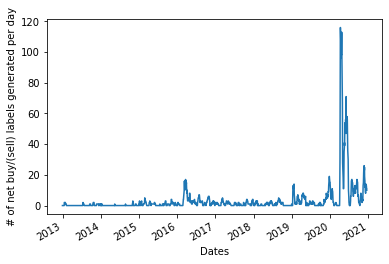

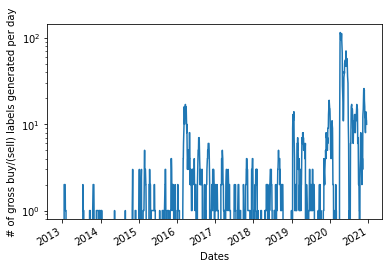

In [833]:
labels = getLabels(prices, trgtPrices=TARGET_PRICES, priceRange=PRICE_RANGE, lookbackDays=HOLD_DAYS, bigMove=BIG_MOVE)
labels.sum(axis=1).plot(ylabel="# of net buy/(sell) labels generated per day")
plt.figure()
print("Average trades per day: ", labels.abs().sum(axis=1).mean(), "median", labels.abs().sum(axis=1).median())
labels.abs().sum(axis=1).plot(ylabel="# of gross buy/(sell) labels generated per day", logy=True)

## Triple Barrier Method Binning of Labels

Functions to:
* Generate labels between {-1, 0, 1} that mean we are short, neutral, or long the loan ID for that entire period

* Generate bins between {0, 1} that mean that the trade was good (\>$0 PNL, or `1`) or bad (negative PNL, or `0`) based on the side we picked in `labels` and the actual price change in the following period. Ignores interest income.

In [834]:
# triple barrier method function
# close:  a pandas series of prices
# events: a pandas dataframe wiht columns
#   - t1:   the timestamp of vertical barrier. When np.nan, no vertical barrier
#.  - trgt: the unit width of the horizontal barriers
# ptSl: a list of two non negative floats
#   - ptSl[0] the factor that multiplies trgt to set the width of the upper barrier. if 0, no upper barrier
#   - ptSl[1] the factor tha multiplesi trgt ot set the width of the lower barrier. if 0, no lower barrier
# molecule a list with the subset of event indices that will be processed by single thread

def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0]>0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index, dtype='float64') #NaNs

    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index = events.index, dtype='float64') #NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] #path prices
        df0 = (df0 / close[loc] -1) * events_.at[loc,'side'] # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min() # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min() # earliest profit taking
    return out

def getVertBarrier(gRaw, tEvents, numDays: int) -> pd.Series:
    t1 = gRaw.index.searchsorted(tEvents + pd.Timedelta(days = numDays))
    t1 = t1[t1 < gRaw.shape[0]]
    t1 = pd.Series(gRaw.index[t1], index=tEvents[:t1.shape[0]]) #NaNs at the end
    t1 = t1.rename('t1')
    return t1


# find the time of the first barrier touch
#  close: pandas series of prices
#  tEvents pandas timeindex of timestamps that will seed every ttriple barrier
#  ptSl a non negative flat that sets the width of th two barriers (symm)
# t1 pandas series with the timestamps of the vert barriers. pass false to disable
# trgt: pandas series of targets, expressed in terms of absolute returns
# minRet minimum target return required for running a triple barrier search
# numThreads  not used yet

# output:
# - t1: timestamp of when the first barrier is touched
# - trgt: the target that was used to generate the horizontal barrier

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents, dtype='datetime64')

    #3) form events object, apply stop loss on t1
    if side is None:
        side_ = pd.Series(1., index=trgt.index)
        ptSl_ = [ptSl, ptSl]
    else:
        side_ = side.loc[trgt.index]
        ptSl_ = ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_ }, axis = 1).dropna(subset=['trgt'])

    df0 = applyPtSlOnT1(close, events, ptSl_, events.index)
    events['t1'] = df0.dropna(how='all').apply(lambda x: x.min(),axis=1)
    if side is None:
        events = events.drop('side', axis = 1)
    events = events.dropna(subset=['t1'])
    return events

# daily vol, reindexed to close
def getDailyVol(close, span=14):
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days = 1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0].values - 1 # daily returns
    df0 = df0.ewm(span=span).std().rename('trgt')
    return df0

def getBins(events, close):
    '''
    Compute event's outcome (including side info, if provided)
    events is a dataframe where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target return
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events) bin in (-1, 1) <- label by price action
    Case 2: ('side' in events) bin in (0,1) <- label by pnl (meta labeling)
    '''
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1']).drop_duplicates()
    px = close.reindex(px, method='bfill')

    #2) create out object
    out = pd.DataFrame(index = events_.index)
    out['ret'] = px.loc[events_['t1']].values / px.loc[events_.index] - 1 
    out['t1'] = events_['t1']
    if 'side' in events_:
        out['ret'] *= events_['side']     # meta-labeling

    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0    # meta-labeling
        out['side'] = events_['side']
    return out

The trading strategy is to observer trading prices of loans trading below 85 (`PRICE_RANGE`), when one of them gains 3 percent (`BIG_MOVE`) in any 5 day period (`LOOKBACK_DAYS`), then we buy the loan on the following days close. We hold the loan for 5 days (`HOLD_DAYS`) and sell. If the position moves in our favor or against us by 3%, then we stop loss or harvest early.

The `getBins` function returns a table of trade outcomes for each loan in {0,1} - 1 if trade made money, 0 if the trade lost money (if `minRet` is set to a % return, then any trade that made less than the value is labeled as `0`).

In [835]:
def pricesToBins(labels: pd.DataFrame, prices: pd.DataFrame, ptSl: Tuple[float, float] = [1., 1.], minRet: float = 0.015, holdDays = 10) -> pd.DataFrame:
  out = pd.DataFrame()
  for ticker in labels.columns:
    dates = labels[ticker][labels[ticker] != 0].index
    t1 = getVertBarrier(prices[ticker], dates, holdDays)
    trgt = getDailyVol(prices[ticker])
    events = getEvents(prices[ticker], dates, ptSl=ptSl, trgt=trgt, minRet=minRet, numThreads=1, t1=t1, side=labels[ticker])
    bins = getBins(events, prices[ticker])
    bins['ticker'] = ticker   
    out = pd.concat([out, bins])

  return out.set_index('ticker', append=True).swaplevel()

In [836]:
bins = pricesToBins(labels, prices, ptSl=PT_SL, minRet=MIN_RET, holdDays=HOLD_DAYS)

Group the events by side and calculate how often the trade makes money. Both events triggered thousands of times so this is a robust sample - but do note that there is some overlap in the events. There were more long than short events. Most of the long trades generated a positive return, while it was roughly 50/50 for the short trades. 

In [837]:
pd.pivot_table(bins, index=['side'], columns=['bin'], values='ret', aggfunc=[len])

len        
bin     0.0     1.0
side               
1.0   984.0  1192.0

Let's take a look at the types of return that each trade produces. The long trades generated a median return of 32 bps in the reasonably short holding period, while the short trades lost 47 bps. This is before trading fees, which on a $1B+ loan can be estimated at ~30 bps each side (60bps round trip).

In [838]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

pd.pivot_table(bins, index=['side'], values='ret', aggfunc=[len, np.mean,  percentile(25), 
                                                            percentile(50), percentile(75), 
                                                            max, min, np.sum])

,len,mean,percentile_25,percentile_50,percentile_75,max,min,sum
,ret,ret,ret,ret,ret,ret,ret,ret
side,,,,,,,,
1.0,2176.0,0.004299,-0.011567,0.00218,0.024205,0.125006,-0.197163,9.353817


Plot the histogram of the returns from the long trades and then the short trades. We clip the histogram window at +/- 10% return to avoid showing the huge outliers.

<AxesSubplot:ylabel='Frequency'>

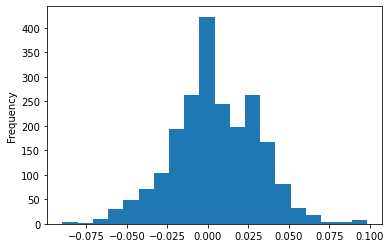

In [839]:
bins[(bins.side == 1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

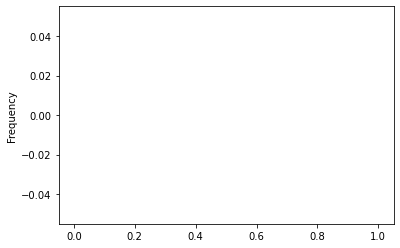

In [840]:
bins[(bins.side == -1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

## Bet Sizing

As mentioned above, most days only have 1 trade per day but most of those trades can be outstanding for over a week, resulting in multiple trades at the same time. There are also times of market volatility when we have hundreds of trades at the same time.

As a reminder, our `bins` dataframe contains `side` labels that indicate whether we are long/short and also `bin` label that indicates if the trade made money. We trained our model to predict this `bin` label, and the confidence of the model in its prediction should be used to size the trade.

In [841]:
def avgActiveSignals(all_signals: pd.DataFrame, signalCol: str='signal') -> pd.Series:
  df1 = pd.DataFrame()
  for ticker, signals in all_signals.groupby(level='ticker'):
    # compute the average signal amoung those active
    #1) time points where signals change (either one starts or one ends)
    tPnts = set(signals['t1'].dropna().values)
    tPnts = tPnts.union(signals.index.get_level_values('Dates'))
    tPnts = list(tPnts)
    tPnts.sort()
    out = pd.Series(dtype="float64")
    for loc in tPnts:
      df0 = (signals.index.get_level_values('Dates') <= loc) & ((loc < signals['t1']) | pd.isnull(signals['t1']))
      act = signals[df0].index
      if len(act) > 0:
        out[loc]=signals.loc[act,signalCol].mean()
      else:
        out[loc] = 0 # no signals active at this time
    df1 = pd.concat([df1, out.to_frame(ticker)], axis=1)

  return df1

signals = avgActiveSignals(bins[['t1', 'side']], signalCol='side')

## Calculating Weights for Labels

To improve our training models, we apply custom weights to each event:

1. We weigh labels higher that have a high uniqueness. For example, if 3 trades are generated in the same loan in the same week, each label is weighted as 1/3 to reduce duplication in the training set.
2. We weigh labels higher if they generated a higher absolute return, so either a big gain or a big loss label will count for more than a small gain/loss. 
3. We  weigh labels higher if they are more recent.

In [842]:
def getWeights(events, prices):
    numCoEvents = mpNumCoEvents(prices.index, events['t1'], events.index)
    numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
    numCoEvents = numCoEvents.reindex(prices.index).fillna(0)
    retW = mpSampleW(events['t1'], numCoEvents, prices, events.index)
    return getTimeDecay(retW, clfLastW=.5)
    
def mpNumCoEvents(closeIdx, t1, molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed

    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1 = t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1 = t1[t1 >= molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(pd.to_datetime([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

def mpSampleW(t1, numCoEvents, close, molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule, dtype='float64')
    for tIn,tOut in t1.loc[wght.index].iteritems():
        beg, end = ret.index.get_loc(tIn), ret.index.get_loc(tOut)
        wght.loc[tIn]=(ret.iloc[beg:end]/numCoEvents.iloc[beg:end]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    # if none of the weights are above zero, make sure the last weight is '1'
    if not clfW.iloc[-1]:
      clfW.iloc[-1] = 1
    if clfLastW>=0: 
        slope=(1.-clfLastW)/clfW.iloc[-1]
    else: 
        slope = 1./((clfLastW + 1) * clfW.iloc[-1])
    const=1. - slope * clfW.iloc[-1]
    clfW=const + slope * clfW
    clfW[clfW < 0] = 0
    return clfW

In [843]:
out = pd.DataFrame()
for ticker in bins.index.unique('ticker'):
    clfW = getWeights(bins.loc[ticker], prices[ticker])
    clfW.index = pd.MultiIndex.from_tuples([(ticker, a) for a in clfW.index], names=['ticker','Dates'])
    out = pd.concat([out, clfW])
out.columns = ['clfW']
bins = pd.concat([bins, out], axis=1)
bins

ret         t1  bin  side      clfW
ticker   Dates                                               
BL055917 2016-10-04  0.008059 2016-10-17  1.0   1.0  0.880915
         2016-10-05  0.000000 2016-10-17  0.0   1.0  1.000000
         2016-10-06  0.000000 2016-10-18  0.0   1.0  1.000000
         2016-10-07  0.000000 2016-10-19  0.0   1.0  1.000000
         2016-10-11  0.000000 2016-10-24  0.0   1.0  1.000000
...                       ...        ...  ...   ...       ...
BL328490 2020-04-07  0.020606 2020-04-20  1.0   1.0  0.893082
         2020-04-08  0.019374 2020-04-20  1.0   1.0  1.000000
BL328851 2020-04-08  0.029236 2020-04-20  1.0   1.0  0.692708
         2020-04-09  0.024514 2020-04-21  1.0   1.0  0.866203
         2020-04-10  0.023857 2020-04-22  1.0   1.0  1.000000

[2176 rows x 5 columns]

<AxesSubplot:>

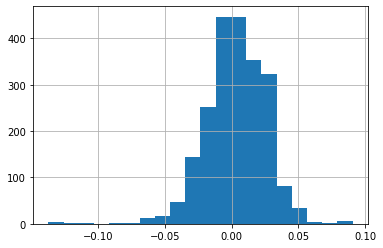

In [844]:
((bins.ret * bins.clfW).reset_index(level='ticker', drop=True)).hist(bins=20)

## Incorporating Loan Metadata

Include meta information:
 the loan maturity date, coupon, iss

* Coupon (in bps, spread over Libor)
* Date issued
* Maturity date
* Amount outstanding
* If the loan is Covenant-lite (Yes or No)



In [845]:
desc = pd.read_csv(prefix + 'loans/loans_desc.csv', parse_dates=['date_issued', 'maturity', ], index_col='id').rename_axis('ticker')
desc = desc.rename(columns={'ticker': 'name'})

In [846]:
# some basic data cleaning steps to make the data ready for the pipeline
desc = desc[['name', 'cpn', 'date_issued', 'maturity', 'amt_out', 'covi_lite', 'loan_type']]
desc.cpn = pd.to_numeric(desc.cpn, errors='coerce')
t = pd.Series({'Y': True, 'N': False})
desc.covi_lite = desc.covi_lite.map(t).astype(bool)
desc.maturity = pd.to_datetime(desc.maturity, errors='coerce')
desc.date_issued = pd.to_datetime(desc.date_issued, errors='coerce')
desc

,name,cpn,date_issued,maturity,amt_out,covi_lite,loan_type
ticker,,,,,,,
BL029150,HCA,150.0,2011-09-30,2022-06-28,3.750000e+09,False,ASSET-BASED REV
BL049152,CZR,525.0,2012-03-01,2017-03-01,5.469243e+09,False,TERM
BL055917,ARCH,450.0,2012-05-16,2018-05-16,1.950000e+09,True,TERM
BL078201,ABEGET,350.0,2012-10-18,2019-10-18,1.954560e+09,True,TERM
BL083751,ROYPHA,200.0,2012-11-02,2016-08-10,2.000000e+09,False,TERM
...,...,...,...,...,...,...,...
BL787561,TXU,350.0,2011-04-07,2014-10-10,2.263638e+10,False,TERM
LN333526,ENDENR,200.0,2007-05-01,2023-01-02,2.000000e+09,False,REV
LN365372,BBEP,NaN,2006-10-10,2019-11-19,1.400000e+09,False,RESERVE-BASED REV


## Training the model with loan features

In [847]:
df = bins.join(desc).drop(columns='name')
df = df.join(prices.rename_axis("ticker", axis='columns').unstack().rename('close'))
df

ret         t1  bin  side      clfW    cpn  \
ticker   Dates                                                         
BL055917 2016-10-04  0.008059 2016-10-17  1.0   1.0  0.880915  450.0   
         2016-10-05  0.000000 2016-10-17  0.0   1.0  1.000000  450.0   
         2016-10-06  0.000000 2016-10-18  0.0   1.0  1.000000  450.0   
         2016-10-07  0.000000 2016-10-19  0.0   1.0  1.000000  450.0   
         2016-10-11  0.000000 2016-10-24  0.0   1.0  1.000000  450.0   
...                       ...        ...  ...   ...       ...    ...   
BL328490 2020-04-07  0.020606 2020-04-20  1.0   1.0  0.893082  250.0   
         2020-04-08  0.019374 2020-04-20  1.0   1.0  1.000000  250.0   
BL328851 2020-04-08  0.029236 2020-04-20  1.0   1.0  0.692708  225.0   
         2020-04-09  0.024514 2020-04-21  1.0   1.0  0.866203  225.0   
         2020-04-10  0.023857 2020-04-22  1.0   1.0  1.000000  225.0   

                    date_issued   maturity       amt_out  covi_lite loan_type  \
ticker   Dates                                                                  
BL055917 2016-10-04  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
         2016-10-05  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
         2016-10-06  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
         2016-10-07  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
         2016-10-11  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
...                         ...        ...           ...        ...       ...   
BL328490 2020-04-07  2020-01-17 2028-04-30  4.610470e+09       True      TERM   
         2020-04-08  2020-01-17 2028-04-30  4.610470e+09       True      TERM   
BL328851 2020-04-08  2020-01-31 2027-03-15  8.699000e+09       True      TERM   
         2020-04-09  2020-01-31 2027-03-15  8.699000e+09       True      TERM   
         2020-04-10  2020-01-31 2027-03-15  8.699000e+09       True      TERM   

                      close  
ticker   Dates               
BL055917 2016-10-04  85.375  
         2016-10-05  86.063  
         2016-10-06  86.063  
         2016-10-07  86.063  
         2016-10-11  86.063  
...                     ...  
BL328490 2020-04-07  94.291  
         2020-04-08  94.405  
BL328851 2020-04-08  94.063  
         2020-04-09  94.313  
         2020-04-10  94.313  

[2176 rows x 12 columns]

In [848]:
class DayCounterAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
      X.maturity = (X.maturity - X.index.get_level_values('Dates')).dt.days
      X.date_issued = (X.index.get_level_values('Dates') - X.date_issued).dt.days
      return X

Process the data, train the model, output the most important features, and predict labels

In [849]:
def getIndMatrix(barIx, t1):
  # Get indicator matrix
  indM = pd.DataFrame(0, index=barIx, columns=range(t1.shape[0]))
  for i, (t0, t1) in enumerate(t1.iteritems()):
    t1 = (t1, t0[1])
    indM.loc[t0:t1, i] = 1.
  return indM

def getAvgUniqueness(indM):
  # average uniqueness from indicator matrix
  c = indM.sum(axis=1) # concurrency
  u = indM.div(c, axis=0) # uniqueness
  return u[u>0].mean().mean() # average uniqueness

class MyPipeline(Pipeline):
  def fit(self, X, y, sample_weight=None, **fit_params):
    if sample_weight is not None:
      fit_params[self.steps[-1][0] + '__sample_weight'] = sample_weight
    return super(MyPipeline, self).fit(X, y, **fit_params)

def trainModel(num_attribs: List[str], cat_attribs: List[str], bool_attribs: List[str], df: pd.DataFrame, test_size: float = 0.3) -> Tuple[any]:
  num_pipeline = Pipeline([
      ('day_counter', DayCounterAdder()),
      ('imputer', SimpleImputer(strategy='median')),
      ('std_scaler', StandardScaler()),
  ])

  bin_pipeline = ColumnTransformer([
          ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
          ("num", num_pipeline, num_attribs),
          ("covi_lite", "passthrough", bool_attribs),
      ])
  
  clf2=RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False, class_weight='balanced_subsample')

  # sort dataset by event date
  df = df.swaplevel().sort_index()

  X = df.drop(columns=['bin', 'ret', 'clfW', 't1'])
  y = df[['bin', 'ret', 't1']]
  clfW = df.clfW
  avgU = getAvgUniqueness(getIndMatrix(X.index, y.t1))
  rf = MyPipeline([
          ('bin', bin_pipeline),
          ('rf', BaggingClassifier(base_estimator=clf2, n_estimators=1000, max_samples=avgU, max_features=1.)),
  ])

  X_train, X_test, y_train, y_test, W_train, W_test = train_test_split(X, y, clfW, test_size=test_size, shuffle=False)

  rf.fit(X_train, y_train.bin, rf__sample_weight=W_train)
  print(f"Train Score: {rf.score(X_train, y_train.bin):2.2f}, Test Score: {rf.score(X_test, y_test.bin):2.2f}")
  y_pred_train, y_pred_test = rf.predict(X_train), rf.predict(X_test)
  y_score_train, y_score_test = rf.predict_proba(X_train)[:,1], rf.predict_proba(X_test)[:,1]

  print(cross_val_score(rf, X, y.bin, cv=5, scoring='f1'))

  cat_columns = [item for item in bin_pipeline.named_transformers_['cat'].get_feature_names(cat_attribs)]
  columns = [*cat_columns, *num_attribs, *bool_attribs,]
  feature_importances = np.mean([
    tree.feature_importances_ for tree in rf['rf'].estimators_], axis=0)
  pd.Series(feature_importances, index=columns).sort_values(ascending=True).plot(kind="barh")

  return X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test, avgU

Print out statistics on the training set

Train Score: 0.75, Test Score: 0.54
[0.67532468 0.66129032 0.68650794 0.70588235 0.69165247]


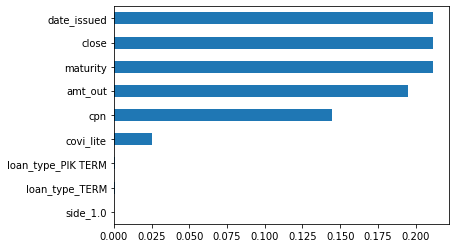

In [850]:
num_attribs = ['cpn', 'date_issued', 'maturity', 'amt_out', 'close']
cat_attribs = ['side', 'loan_type']

X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test, avgU = trainModel(num_attribs, cat_attribs, ['covi_lite'], df)

Precision: 0.72, Recall: 0.88, Area under curve: 0.74
[[429 277]
 [ 99 718]]


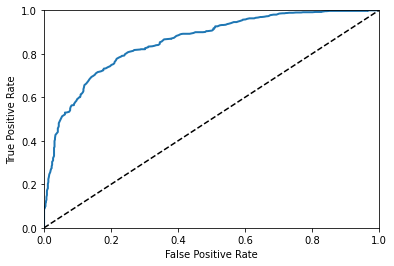

In [851]:
def printCurve(X, y, y_pred, y_score):
  print(f"Precision: {precision_score(y, y_pred):2.2f}, Recall: {recall_score(y, y_pred):2.2f}, Area under curve: {roc_auc_score(y, y_pred):2.2f}")
  print(confusion_matrix(y, y_pred))

  fpr, tpr, thresholds = roc_curve(y, y_score)

  def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

  plot_roc_curve(fpr, tpr)
  plt.show()

printCurve(X_train, y_train.bin, y_pred_train, y_score_train)

Statistics on the testing set show that the meta-labeling model is just a toss up at predicting which trade to take or not - we need more metadata about each loan and event to accurately predict this.

Precision: 0.58, Recall: 0.69, Area under curve: 0.51
[[ 90 188]
 [115 260]]


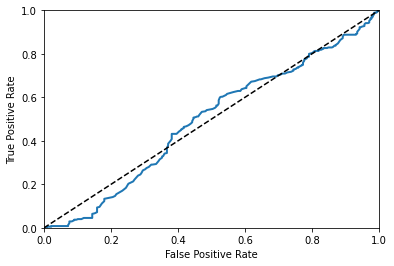

In [852]:
printCurve(X_test, y_test.bin, y_pred_test, y_score_test)

In [853]:
def discreteSignal(signal0: pd.DataFrame, stepSize: float) -> pd.DataFrame:
  signal1= ( signal0 / stepSize).round() * stepSize
  signal1[signal1 > 1] = 1 # cap
  signal1[signal1 < -1] = -1 #floor
  return signal1


def getSignal(events, stepSize, prob, pred, numClasses):
  # get signals from predictions
  if prob.shape[0] == 0: 
    return pd.Series(dtype='float64')
  #1) generate signals from multinomial cassification
  signal0 = (prob - 1. / numClasses) / (prob * (1. - prob)) ** .5 #t-value of OvR
  signal0 = pred * (2* norm.cdf(signal0) - 1) # signal=side*size
  if 'side' in events:
    signal0 *= events.loc[signal0.index, 'side'] # meta labeling
  #2) compute average signal among those open
  df0 = signal0.to_frame('signal').join(events[['t1']], how='left')
  df0 = avgActiveSignals(df0)
  signal1 = discreteSignal(signal0=df0, stepSize=stepSize)
  return signal1

In [854]:
def backtest(y_test, y_score_test, y_pred_test, df, prices, stepSize: float = 0.05) -> pd.DataFrame:
  idx = y_test.shape[0]
  events = df.swaplevel().sort_index()[['side', 't1']].iloc[-idx:]
  signals = getSignal(events, stepSize=stepSize, prob=pd.Series(y_score_test, index=events.index), pred=pd.Series(y_pred_test, index=events.index), numClasses=2)
  price_idx = prices.index.searchsorted(events.index[0][0])
  positions = signals.reindex(index=prices.index[price_idx:]).fillna(method='pad').fillna(0)

  fig, ax = plt.subplots(3, 1, figsize=(10,10), sharex=True)
  numTrades = positions.abs().sum(axis=1)
  numTrades.plot(ax=ax[0], title="# of Positions")
  positions = positions.divide(numTrades, axis=0)
  positions.abs().sum(axis=1).plot(ax=ax[1], title="Sum of Gross Positions after Weighting")
  #positions.sum(axis=1).plot(ax=ax[1])
  print("Number of trading days with a position", positions[positions.sum(axis=1) != 0].shape[0])

  portfolio_rtn_df = positions.multiply(prices.pct_change().fillna(0).iloc[price_idx:]).sum(axis=1)
  portfolio_cum_rtn_df = (1 + portfolio_rtn_df).cumprod() - 1
  portfolio_cum_rtn_df.plot(ax=ax[2], title="Portfolio PnL, %")
  plt.tight_layout()
  return signals, positions

Plot the backtest of results

Number of trading days with a position 108


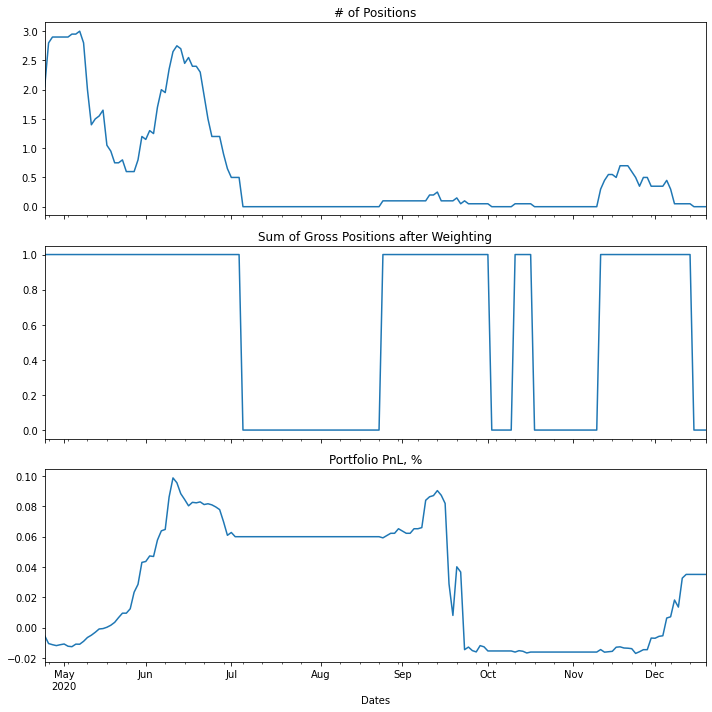

In [855]:
signals, positions = backtest(y_test, y_score_test, y_pred_test, df, prices)

## Loan Ratings 
Let's improve our model by incorporating ratings on our loans. We have S&P and Moody's corporate ratings on each borrower. Our data is sampled quarterly, so we can only assign a rating for each event that was current as of the previous quarter end.

In [856]:
moody = pd.read_csv(prefix + 'loans/loans_moody.csv', index_col='id').rename_axis('ticker').rename_axis('month',axis=1).unstack().rename('moody')
snp = pd.read_csv(prefix + 'loans/loans_snp.csv', index_col='id').rename_axis('ticker').rename_axis('month',axis=1).unstack().rename('snp')
moody.index.set_levels(pd.PeriodIndex(pd.to_datetime(moody.index.levels[0]), freq='M'), level=0, inplace=True)
snp.index.set_levels(pd.PeriodIndex(pd.to_datetime(snp.index.levels[0]), freq='M'), level=0, inplace=True)
print(moody.unique(), snp.unique(), sep='\n')

[nan 'B2' 'Ba3' 'B1' 'Baa2' 'Ba2' 'Caa1' 'Baa3' 'Caa3' '(P)Ba2' 'Ba1' 'B3'
 '(P)Ba1' '(P)Ba3' 'Caa2' 'WR' 'A3' '(P)B1' 'NR' '(P)Baa2' 'Ca' '(P)Baa3'
 '(P)B2' 'Baa1' 'A2' 'C' 'B2u']
['BB' 'B' nan 'B+' 'BB-' 'BB+' 'B-' 'BBB-' 'BBB' 'CCC' 'CCC+' 'CCC-' 'CC'
 'NR' 'A' 'D' 'A-' 'BB+u' '(P)BB-' 'BBB+' 'C' '(P)B+']


In [857]:
moody_scale = {
    'A1': 1,
    'A2': 1,
    'A3': 1,
    'Baa1': 2,
    'Baa2': 2,
    '(P)Baa2': 2,
    'Baa3': 2,
    '(P)Baa3': 2,
    'Ba1': 3,
    'Ba1u': 3,
    '(P)Ba1': 3,
    '(P)Ba2': 3,
    'Ba2': 3,
    'Ba2u': 3,
    '(P)Ba3': 3,
    'Ba3': 3,
    'B1': 4,
    '(P)B1': 4,
    'B2':  5,
    'B2u': 5,
    '(P)B2': 5,
    'B3': 6,
    'Caa1': 7,
    'Caa2' : 7,
    'Caa3': 7,
    'Ca': 7,
    'C': 7,
}

snp_scale = {
    'A+': 1,
    'A': 1,
    'A-': 1,
    'BBB+': 2,
    'BBB': 2,
    'BBB-': 2,
    'BB+': 3,
    'BB+u': 3,
    'BB': 3,
    'BB-': 3,
    '(P)BB-': 3,
    'B+': 4,
    '(P)B+': 4,
    'B': 5,
    'B-': 6,
    'CCC+': 7,
    'CCC': 7,
    'CCC-': 7,
    'CC': 7,
    'C': 7,
    'D': 7,
}

moody_num = moody.map(moody_scale).fillna(5)
snp_num = snp.map(snp_scale).fillna(5)
avg_rating = pd.concat([moody_num,snp_num],axis=1).mean(axis=1).rename('avg_rating')

In [858]:
df_rating = df.reset_index(level='ticker')
df_rating['month'] = pd.PeriodIndex(df_rating.index, freq='M') - 1
df_rating = df_rating.set_index('ticker', append=True).swaplevel()
df_rating = df_rating.join(avg_rating, on=['month', 'ticker'])
df_rating = df_rating.join(moody_num, on=['month', 'ticker'])
df_rating

ret         t1  bin  side      clfW    cpn  \
ticker   Dates                                                         
BL055917 2016-10-04  0.008059 2016-10-17  1.0   1.0  0.880915  450.0   
         2016-10-05  0.000000 2016-10-17  0.0   1.0  1.000000  450.0   
         2016-10-06  0.000000 2016-10-18  0.0   1.0  1.000000  450.0   
         2016-10-07  0.000000 2016-10-19  0.0   1.0  1.000000  450.0   
         2016-10-11  0.000000 2016-10-24  0.0   1.0  1.000000  450.0   
...                       ...        ...  ...   ...       ...    ...   
BL328490 2020-04-07  0.020606 2020-04-20  1.0   1.0  0.893082  250.0   
         2020-04-08  0.019374 2020-04-20  1.0   1.0  1.000000  250.0   
BL328851 2020-04-08  0.029236 2020-04-20  1.0   1.0  0.692708  225.0   
         2020-04-09  0.024514 2020-04-21  1.0   1.0  0.866203  225.0   
         2020-04-10  0.023857 2020-04-22  1.0   1.0  1.000000  225.0   

                    date_issued   maturity       amt_out  covi_lite loan_type  \
ticker   Dates                                                                  
BL055917 2016-10-04  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
         2016-10-05  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
         2016-10-06  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
         2016-10-07  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
         2016-10-11  2012-05-16 2018-05-16  1.950000e+09       True      TERM   
...                         ...        ...           ...        ...       ...   
BL328490 2020-04-07  2020-01-17 2028-04-30  4.610470e+09       True      TERM   
         2020-04-08  2020-01-17 2028-04-30  4.610470e+09       True      TERM   
BL328851 2020-04-08  2020-01-31 2027-03-15  8.699000e+09       True      TERM   
         2020-04-09  2020-01-31 2027-03-15  8.699000e+09       True      TERM   
         2020-04-10  2020-01-31 2027-03-15  8.699000e+09       True      TERM   

                      close    month  avg_rating  moody  
ticker   Dates                                           
BL055917 2016-10-04  85.375  2016-09         6.0    5.0  
         2016-10-05  86.063  2016-09         6.0    5.0  
         2016-10-06  86.063  2016-09         6.0    5.0  
         2016-10-07  86.063  2016-09         6.0    5.0  
         2016-10-11  86.063  2016-09         6.0    5.0  
...                     ...      ...         ...    ...  
BL328490 2020-04-07  94.291  2020-03         4.0    4.0  
         2020-04-08  94.405  2020-03         4.0    4.0  
BL328851 2020-04-08  94.063  2020-03         2.5    3.0  
         2020-04-09  94.313  2020-03         2.5    3.0  
         2020-04-10  94.313  2020-03         2.5    3.0  

[2176 rows x 15 columns]

In [859]:
num_attribs += ['avg_rating']
cat_attribs += ['moody']

Train Score: 0.78, Test Score: 0.50
[0.69836066 0.6796875  0.70075758 0.70181818 0.67572156]


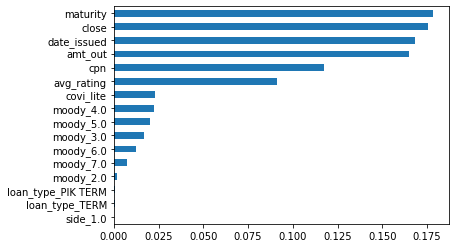

In [860]:
X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test, avgU = trainModel(num_attribs, cat_attribs, ['covi_lite'], df_rating)

Precision: 0.74, Recall: 0.90, Area under curve: 0.77
[[451 255]
 [ 80 737]]


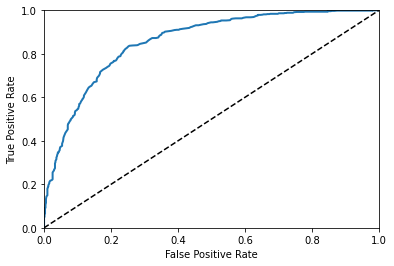

In [861]:
printCurve(X_train, y_train.bin, y_pred_train, y_score_train)

As a result of adding credit ratings, the accuracy of the labeling model did not improve

Precision: 0.56, Recall: 0.62, Area under curve: 0.48
[[ 96 182]
 [144 231]]


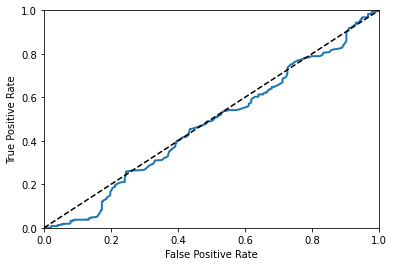

In [862]:
printCurve(X_test, y_test.bin, y_pred_test, y_score_test)

Number of trading days with a position 107


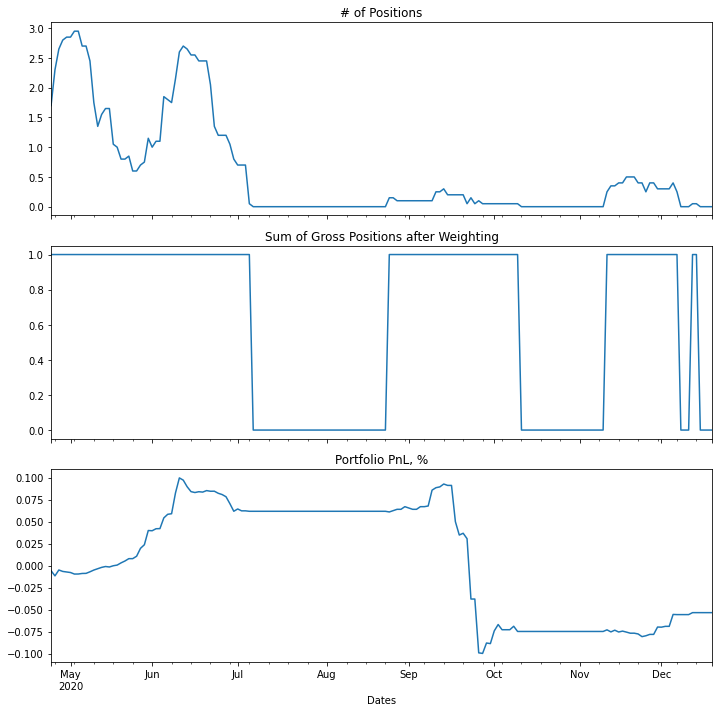

In [863]:
signals, positions = backtest(y_test, y_score_test, y_pred_test, df, prices)

# Bond Dataset

## Identifying Events

Once again we read in the historical data from Bloomberg (BVAL). The parameters are similar to the loan screen, focusing on CUSIPs in USD for US incorporated corporates, with outstanding bonds > $1B in size, Sr. Uns rank, and HY ratings. The data is similar except coupon is measured in % rather than bps, and there is no Covenant Lite column or Loan Type column. The data starts in 2015 due to bloomberg limitation, so we have less training set data for bonds.

In [864]:
# read in historical prices
prices_2019_2020 = pd.read_csv(prefix + 'bonds/bonds_data_2019_2020.csv', parse_dates=['Dates'], index_col='Dates')
prices_2017_2018 = pd.read_csv(prefix + 'bonds/bonds_data_2017_2018.csv', parse_dates=['Dates'], index_col='Dates')
prices_2015_2016 = pd.read_csv(prefix + 'bonds/bonds_data_2015_2016.csv', parse_dates=['Dates'], index_col='Dates')

prices = pd.concat([prices_2015_2016, prices_2017_2018, prices_2019_2020], join="outer", verify_integrity=True)
print("(# dates, # tickers)", prices.shape)
prices = prices.fillna(method="pad")

(# dates, # tickers) (1533, 702)


Median price of event trigger 101.62


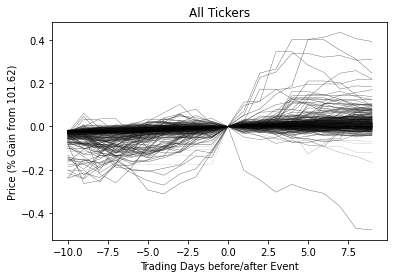

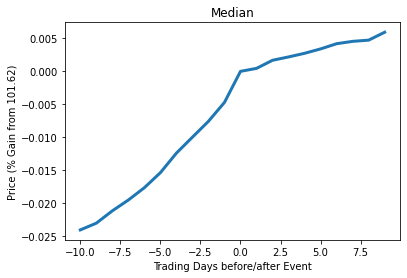

In [865]:
TARGET_PRICES = [None, None]

plotPricesAfterBigMove(prices, trgtPrice=TARGET_PRICES[0], priceRange=PRICE_RANGE, bigMove=BIG_MOVE, numDays=LOOKBACK_DAYS)

Median price of event trigger 100.68


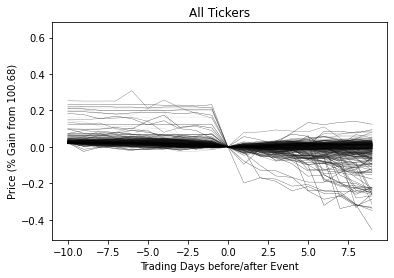

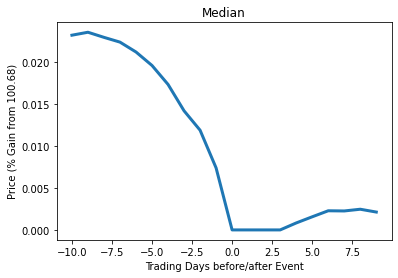

In [866]:
plotPricesAfterBigMove(prices, trgtPrice=TARGET_PRICES[1], priceRange=PRICE_RANGE, bigMove=-BIG_MOVE, numDays=LOOKBACK_DAYS)

## Labeling, Binning, Weighing

In [867]:
labels = getLabels(prices, trgtPrices=TARGET_PRICES, priceRange=PRICE_RANGE, lookbackDays=HOLD_DAYS, bigMove=BIG_MOVE)

In [868]:
bins = pricesToBins(labels, prices, ptSl=PT_SL, minRet=MIN_RET, holdDays=HOLD_DAYS)
bins

ret         t1  bin  side
ticker   Dates                                     
EK403000 2015-01-21 -0.193799 2015-02-02  0.0  -1.0
         2015-01-22 -0.160353 2015-02-03  0.0  -1.0
         2015-01-23 -0.173441 2015-02-04  0.0  -1.0
         2015-01-26 -0.317472 2015-02-09  0.0  -1.0
         2015-01-27 -0.242342 2015-02-09  0.0  -1.0
...                       ...        ...  ...   ...
AN253133 2020-04-24  0.003959 2020-05-06  1.0   1.0
         2020-04-27  0.008037 2020-05-11  1.0   1.0
         2020-04-28  0.007020 2020-05-11  1.0   1.0
         2020-04-29  0.007010 2020-05-11  1.0   1.0
         2020-04-30  0.007699 2020-05-12  1.0   1.0

[24680 rows x 4 columns]

In [869]:
pd.pivot_table(bins, index=['side'], columns=['bin'], values='ret', aggfunc=[len])

len        
bin      0.0     1.0
side                
-1.0  6659.0  5931.0
 1.0  5355.0  6735.0

In [870]:
pd.pivot_table(bins, index=['side'], values='ret', aggfunc=[len, np.mean,  percentile(25), 
                                                            percentile(50), percentile(75), 
                                                            max, min, np.sum])

,len,mean,percentile_25,percentile_50,percentile_75,max,min,sum
,ret,ret,ret,ret,ret,ret,ret,ret
side,,,,,,,,
-1.0,12590.0,-0.019899,-0.058446,-0.000000,0.045226,0.826923,-12.888889,-250.522931
1.0,12090.0,0.008907,-0.020757,0.007285,0.040189,0.725000,-0.807692,107.690049


<AxesSubplot:ylabel='Frequency'>

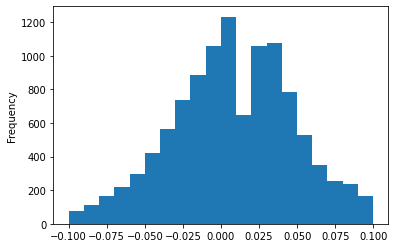

In [871]:
bins[(bins.side == 1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

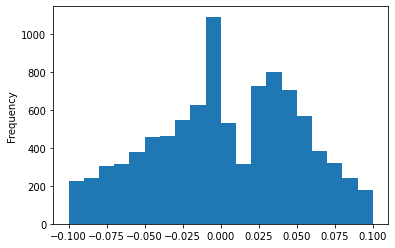

In [872]:
bins[(bins.side == -1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

In [873]:
out = pd.DataFrame()
for ticker in bins.index.unique('ticker'):
    clfW = getWeights(bins.loc[ticker], prices[ticker])
    clfW.index = pd.MultiIndex.from_tuples([(ticker, a) for a in clfW.index], names=['ticker','Dates'])
    out = pd.concat([out, clfW])
out.columns = ['clfW']
bins = pd.concat([bins, out], axis=1)
bins

ret         t1  bin  side      clfW
ticker   Dates                                               
EK403000 2015-01-21 -0.193799 2015-02-02  0.0  -1.0  0.505239
         2015-01-22 -0.160353 2015-02-03  0.0  -1.0  0.510305
         2015-01-23 -0.173441 2015-02-04  0.0  -1.0  0.512654
         2015-01-26 -0.317472 2015-02-09  0.0  -1.0  0.516143
         2015-01-27 -0.242342 2015-02-09  0.0  -1.0  0.518695
...                       ...        ...  ...   ...       ...
AN253133 2020-04-24  0.003959 2020-05-06  1.0   1.0  0.975143
         2020-04-27  0.008037 2020-05-11  1.0   1.0  0.982101
         2020-04-28  0.007020 2020-05-11  1.0   1.0  0.988319
         2020-04-29  0.007010 2020-05-11  1.0   1.0  0.994297
         2020-04-30  0.007699 2020-05-12  1.0   1.0  1.000000

[24680 rows x 5 columns]

## Incorporating Bond Metadata

In [874]:
desc = pd.read_csv(prefix + 'bonds/bonds_desc.csv', parse_dates=['date_issued', 'maturity', ], index_col='id').rename_axis('ticker')
desc = desc.rename(columns={'ticker': 'name'})

In [875]:
# some basic data cleaning steps to make the data ready for the pipeline
desc = desc[['name', 'cpn', 'date_issued', 'maturity', 'amt_out']]
desc.cpn = pd.to_numeric(desc.cpn, errors='coerce')
desc.maturity = pd.to_datetime(desc.maturity, errors='coerce')
desc.date_issued = pd.to_datetime(desc.date_issued, errors='coerce')
desc

,name,cpn,date_issued,maturity,amt_out
ticker,,,,,
EK718211,SNEC,6.125,2015-01-23,2023-01-15,1150000000
QZ888409,RAX,8.625,2016-10-25,2024-11-15,1200000000
AR871586,MDR,10.625,2018-04-04,2024-05-01,1300000000
JK964020,FTR,11.000,2016-04-28,2025-09-15,3598050000
AP362087,WSTC,8.500,2017-10-03,2025-10-15,1150000000
...,...,...,...,...,...
EH880957,TWC,6.750,2009-06-24,2039-06-15,1500000000
EG874835,TWC,6.550,2007-09-25,2037-05-01,1500000000
EI807807,TWC,5.500,2011-09-07,2041-09-01,1250000000


In [876]:
df = bins.join(desc).drop(columns='name')
df = df.join(prices.rename_axis("ticker", axis='columns').unstack().rename('close'))
df

ret         t1  bin  side      clfW   cpn  \
ticker   Dates                                                        
EK403000 2015-01-21 -0.193799 2015-02-02  0.0  -1.0  0.505239  9.75   
         2015-01-22 -0.160353 2015-02-03  0.0  -1.0  0.510305  9.75   
         2015-01-23 -0.173441 2015-02-04  0.0  -1.0  0.512654  9.75   
         2015-01-26 -0.317472 2015-02-09  0.0  -1.0  0.516143  9.75   
         2015-01-27 -0.242342 2015-02-09  0.0  -1.0  0.518695  9.75   
...                       ...        ...  ...   ...       ...   ...   
AN253133 2020-04-24  0.003959 2020-05-06  1.0   1.0  0.975143  6.75   
         2020-04-27  0.008037 2020-05-11  1.0   1.0  0.982101  6.75   
         2020-04-28  0.007020 2020-05-11  1.0   1.0  0.988319  6.75   
         2020-04-29  0.007010 2020-05-11  1.0   1.0  0.994297  6.75   
         2020-04-30  0.007699 2020-05-12  1.0   1.0  1.000000  6.75   

                    date_issued   maturity       amt_out   close  
ticker   Dates                                                    
EK403000 2015-01-21  2014-07-22 2020-02-15  2.250000e+09  26.125  
         2015-01-22  2014-07-22 2020-02-15  2.250000e+09  28.063  
         2015-01-23  2014-07-22 2020-02-15  2.250000e+09  27.750  
         2015-01-26  2014-07-22 2020-02-15  2.250000e+09  28.938  
         2015-01-27  2014-07-22 2020-02-15  2.250000e+09  30.688  
...                         ...        ...           ...     ...  
AN253133 2020-04-24  2017-04-20 2025-06-01  1.230000e+09  96.745  
         2020-04-27  2017-04-20 2025-06-01  1.230000e+09  97.047  
         2020-04-28  2017-04-20 2025-06-01  1.230000e+09  97.145  
         2020-04-29  2017-04-20 2025-06-01  1.230000e+09  97.146  
         2020-04-30  2017-04-20 2025-06-01  1.230000e+09  97.023  

[24680 rows x 10 columns]

## Train the Model

Train Score: 0.65, Test Score: 0.53
[0.41944626 0.62910061 0.4405051  0.47753086 0.68946604]


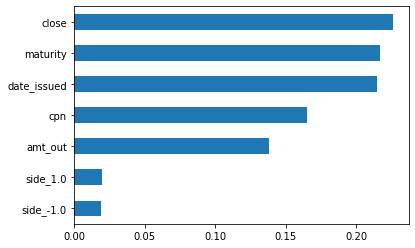

In [877]:
num_attribs = ['cpn', 'date_issued', 'maturity', 'amt_out', 'close']
cat_attribs = ['side']

X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test, avgU = trainModel(num_attribs, cat_attribs, [], df)

Precision: 0.64, Recall: 0.73, Area under curve: 0.64
[[4680 3647]
 [2452 6497]]


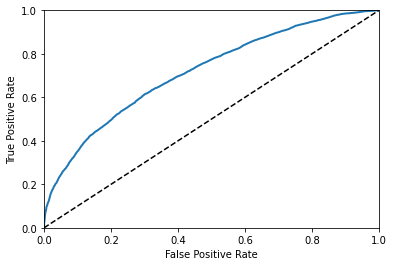

In [878]:
printCurve(X_train, y_train.bin, y_pred_train, y_score_train)

Precision: 0.52, Recall: 0.91, Area under curve: 0.53
[[ 562 3125]
 [ 322 3395]]


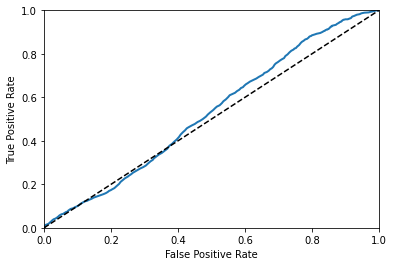

In [879]:
printCurve(X_test, y_test.bin, y_pred_test, y_score_test)

Number of trading days with a position 180


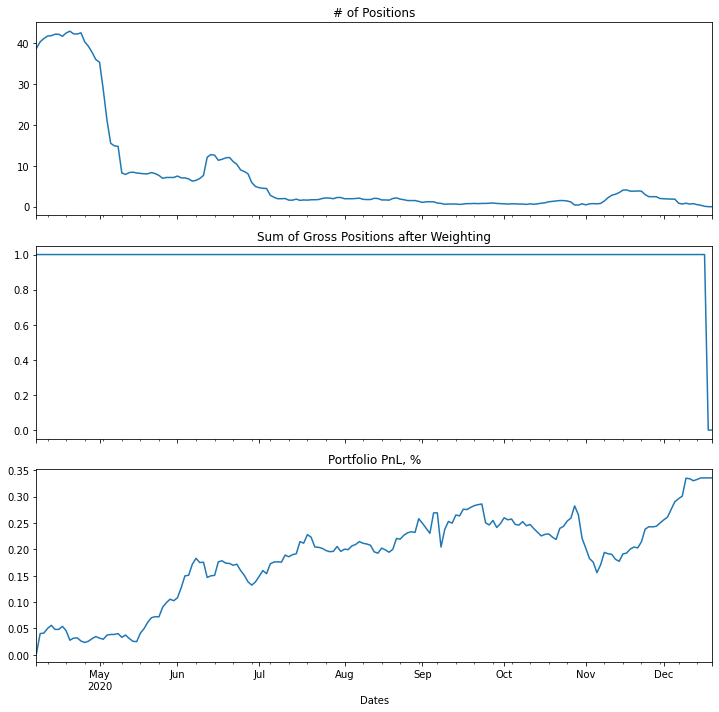

In [880]:
signals, positions = backtest(y_test, y_score_test, y_pred_test, df, prices)

## Bond Ratings

In [881]:
moody = pd.read_csv(prefix + 'bonds/bonds_moody.csv', index_col='id').rename_axis('ticker').rename_axis('month',axis=1).unstack().rename('moody')
snp = pd.read_csv(prefix + 'bonds/bonds_snp.csv', index_col='id').rename_axis('ticker').rename_axis('month',axis=1).unstack().rename('snp')
moody.index.set_levels(pd.PeriodIndex(pd.to_datetime(moody.index.levels[0]), freq='M'), level=0, inplace=True)
snp.index.set_levels(pd.PeriodIndex(pd.to_datetime(snp.index.levels[0]), freq='M'), level=0, inplace=True)
print(moody.unique(), snp.unique(), sep='\n')

['B3' nan 'Baa2' 'Ba1' 'Caa1' 'B2' 'Baa3' 'A1' 'Ba3' 'B1' 'Ba2' 'Baa1'
 '(P)Baa2' 'A3' 'A2' 'Ca' 'WR' 'Caa2' 'Caa3' 'C' '(P)Ba2' 'Ba2u' 'Ba1u']
['B-' nan 'BBB' 'BBB-' 'B' 'BB-' 'A' 'BB' 'B+' 'CCC+' 'BB+' 'BBB+' 'A-'
 'CCC-' 'CCC' 'NR' 'C' 'D' 'CC' 'BB-u']


In [882]:
moody_num = moody.map(moody_scale).fillna(5)
snp_num = snp.map(snp_scale).fillna(5)
avg_rating = pd.concat([moody_num,snp_num],axis=1).mean(axis=1).rename('avg_rating')

In [883]:
df_rating = df.reset_index(level='ticker')
df_rating['month'] = pd.PeriodIndex(df_rating.index, freq='M') - 1
df_rating = df_rating.set_index('ticker', append=True).swaplevel()
df_rating = df_rating.join(avg_rating, on=['month', 'ticker'])
df_rating = df_rating.join(moody_num, on=['month', 'ticker'])
df_rating

ret         t1  bin  side      clfW   cpn  \
ticker   Dates                                                        
EK403000 2015-01-21 -0.193799 2015-02-02  0.0  -1.0  0.505239  9.75   
         2015-01-22 -0.160353 2015-02-03  0.0  -1.0  0.510305  9.75   
         2015-01-23 -0.173441 2015-02-04  0.0  -1.0  0.512654  9.75   
         2015-01-26 -0.317472 2015-02-09  0.0  -1.0  0.516143  9.75   
         2015-01-27 -0.242342 2015-02-09  0.0  -1.0  0.518695  9.75   
...                       ...        ...  ...   ...       ...   ...   
AN253133 2020-04-24  0.003959 2020-05-06  1.0   1.0  0.975143  6.75   
         2020-04-27  0.008037 2020-05-11  1.0   1.0  0.982101  6.75   
         2020-04-28  0.007020 2020-05-11  1.0   1.0  0.988319  6.75   
         2020-04-29  0.007010 2020-05-11  1.0   1.0  0.994297  6.75   
         2020-04-30  0.007699 2020-05-12  1.0   1.0  1.000000  6.75   

                    date_issued   maturity       amt_out   close    month  \
ticker   Dates                                                              
EK403000 2015-01-21  2014-07-22 2020-02-15  2.250000e+09  26.125  2014-12   
         2015-01-22  2014-07-22 2020-02-15  2.250000e+09  28.063  2014-12   
         2015-01-23  2014-07-22 2020-02-15  2.250000e+09  27.750  2014-12   
         2015-01-26  2014-07-22 2020-02-15  2.250000e+09  28.938  2014-12   
         2015-01-27  2014-07-22 2020-02-15  2.250000e+09  30.688  2014-12   
...                         ...        ...           ...     ...      ...   
AN253133 2020-04-24  2017-04-20 2025-06-01  1.230000e+09  96.745  2020-03   
         2020-04-27  2017-04-20 2025-06-01  1.230000e+09  97.047  2020-03   
         2020-04-28  2017-04-20 2025-06-01  1.230000e+09  97.145  2020-03   
         2020-04-29  2017-04-20 2025-06-01  1.230000e+09  97.146  2020-03   
         2020-04-30  2017-04-20 2025-06-01  1.230000e+09  97.023  2020-03   

                     avg_rating  moody  
ticker   Dates                          
EK403000 2015-01-21         7.0    7.0  
         2015-01-22         7.0    7.0  
         2015-01-23         7.0    7.0  
         2015-01-26         7.0    7.0  
         2015-01-27         7.0    7.0  
...                         ...    ...  
AN253133 2020-04-24         7.0    7.0  
         2020-04-27         7.0    7.0  
         2020-04-28         7.0    7.0  
         2020-04-29         7.0    7.0  
         2020-04-30         7.0    7.0  

[24680 rows x 13 columns]

Add the average numerical rating as a numerical attribute but also adding the numerical moody rating as a categorical category.

In [884]:
num_attribs += ['avg_rating']
cat_attribs += ['moody']

Train Score: 0.66, Test Score: 0.54
[0.48191808 0.64571598 0.41759304 0.45475401 0.6795763 ]


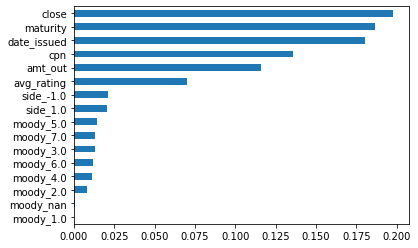

In [885]:
X_train, X_test, y_train, y_test, y_pred_train, y_pred_test, y_score_train, y_score_test,avgU = trainModel(num_attribs, cat_attribs, [], df_rating)

Precision: 0.64, Recall: 0.76, Area under curve: 0.65
[[4521 3806]
 [2113 6836]]


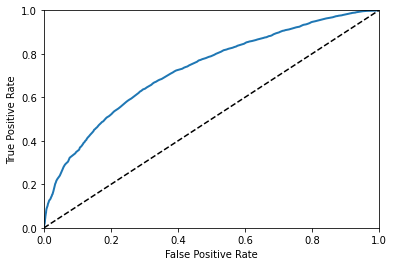

In [886]:
printCurve(X_train, y_train.bin, y_pred_train, y_score_train)

Precision: 0.52, Recall: 0.90, Area under curve: 0.54
[[ 636 3051]
 [ 355 3362]]


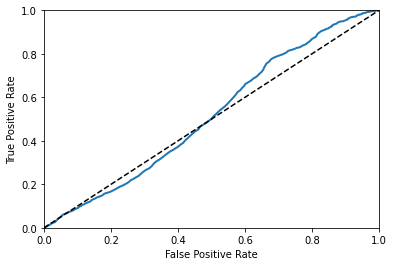

In [887]:
printCurve(X_test, y_test.bin, y_pred_test, y_score_test)

Number of trading days with a position 180


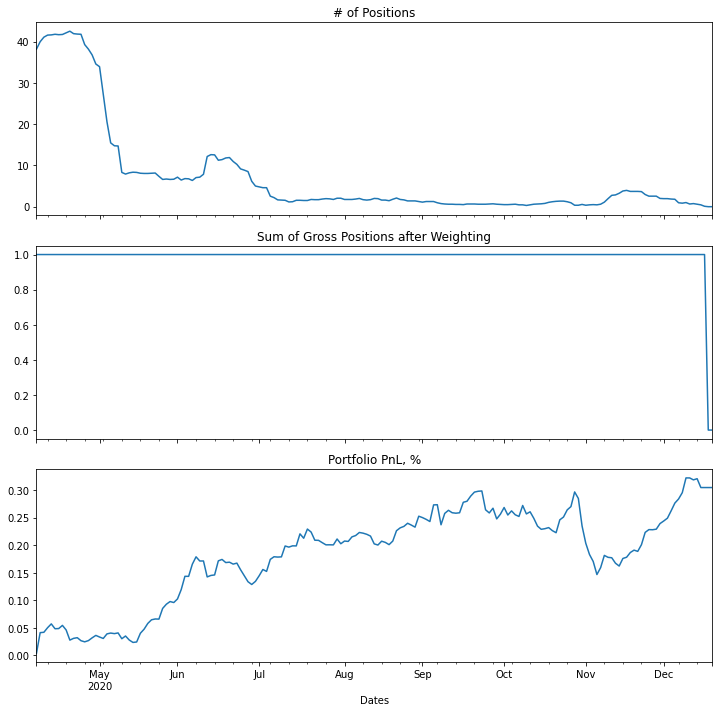

In [888]:
signals, positions = backtest(y_test, y_score_test, y_pred_test, df, prices, stepSize=.05)

In [889]:
just_buy = (prices ** 0).loc[signals.index]
just_buy = just_buy.divide(just_buy.sum(1), axis=0)

<AxesSubplot:title={'center':'Portfolio PnL, %'}>

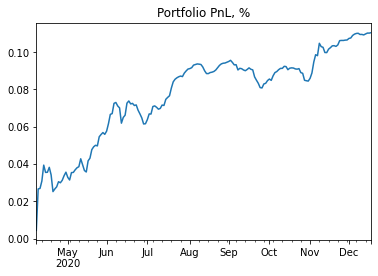

In [890]:
portfolio_rtn_df = just_buy.multiply(prices.pct_change().fillna(0).loc[signals.index]).sum(axis=1)
portfolio_cum_rtn_df = (1 + portfolio_rtn_df).cumprod() - 1
portfolio_cum_rtn_df.plot(title="Portfolio PnL, %")

In [891]:
label_grid = {
    'trgtPrices': [[80,80], ], 
    'priceRange': [2], 
    'bigMove': [2,]  
}

bin_grid = {
    'minRet': [.02],
    'holdDays': [8,],
    'ptSl': [[1, 2], ],
}

best_buy, best_sell = 0, 0
for i, label_param in enumerate(ParameterGrid(label_grid)):
  labels = getLabels(prices, **label_param, lookbackDays=HOLD_DAYS)
  print(i, label_param)
  for j, bin_param in enumerate(ParameterGrid(bin_grid)):
    bins = pricesToBins(labels, prices, **bin_param)
    buy = bins[bins.side == 1].bin.mean()
    sell = bins[bins.side == -1].bin.mean()
    print(f"\t\t{j}, {bin_param}, {buy:2.2f}{'***' if best_buy < buy else ''}, {sell:2.2f}{'***' if best_sell < sell else ''}")
    best_buy = max(best_buy, buy)
    best_sell = max(best_sell, sell)

0 {'bigMove': 2, 'priceRange': 2, 'trgtPrices': [80, 80]}
		0, {'holdDays': 8, 'minRet': 0.02, 'ptSl': [1, 2]}, 0.64***, 0.44***
